In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# https://drive.google.com/open?id=1ZmDAn2whHFm4ok6jFc2gpH4PnyDFLvGN

In [0]:
downloaded = drive.CreateFile({'id':"13xmiSh8AgQjj6BJ7Dxu_byo59bnlUT8h"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv')        # replace the file name with your file

In [0]:
import numpy as np


class GMM:
    """
    Implements the expectation-maximisation (EM) algorithm for the
    Gaussian mixture model (GMM). The algorithm is based on the
    pseudo-code described in the book by C. Bishop "Pattern Recognition
    and Machine Learning", chapter 9.
    """
    def __init__(self,
                 n_components,
                 means=None,
                 covariances=None,
                 mixing_probs=None,
                 epsilon=1e-6,
                 callback = None,
                 features = None):
        """
        Arguments:
        n_components -- number of mixtures (components) to fit
        means -- (optional) initial array of mean vectors (numpy array of numpy arrays)
        covariances -- (optional) initial array of covariance matrices (numpy array of numpy arrays)
        mixing_probs -- (optional) initial vector (numpy array) of mixing probabilities
        epsilon -- (optional) convergence criterion
        """
        self.n_components = n_components
        self.means = means
        self.covariances = covariances
        self.mixing_probs = mixing_probs
        self.epsilon = epsilon
        self.__callback = callback
        self.data = features

    def fit(self, features):
        """
        Fits a GMM into a set of feature data.
        Arguments:
        features -- input features data set
        """
        # Initialise
        self.data = features
        n, _ = features.shape
        norm_densities = np.empty((n, self.n_components), np.float)
        responsibilities = np.empty((n, self.n_components), np.float)
        old_log_likelihood = 0
        self._initialise_parameters(features)
        print('features shape: ', features[0].shape)
        while True:
            # Compute normal densities
            for i in np.arange(n):
                x = features[i]
              
                for j in np.arange(self.n_components):
                    norm_densities[i][j] = self.multivariate_normal_pdf(x, self.means[j], self.covariances[j])

            # Estimate log likelihood
            log_vector = np.log(np.array([np.dot(self.mixing_probs.T, norm_densities[i]) for i in np.arange(n)]))
            log_likelihood = np.dot(log_vector.T, np.ones(n))
            
            self.call_back()

            # Check for convergence
            if np.absolute(log_likelihood - old_log_likelihood) < self.epsilon:
                break

            # E-step: evaluate responsibilities
            for i in np.arange(n):
                x = features[i]
                denominator = np.dot(self.mixing_probs.T, norm_densities[i])
                for j in np.arange(self.n_components):
                    responsibilities[i][j] = self.mixing_probs[j] * norm_densities[i][j] / denominator

            # M-step: re-estimate the parameters
            for i in np.arange(self.n_components):
                responsibility = (responsibilities.T)[i]

                # Common denominator
                denominator = np.dot(responsibility.T, np.ones(n))

                # Update mean
                self.means[i] = np.dot(responsibility.T, features) / denominator
                #print('means[i] : ', self.means[i].shape)
                # Update covariance
                difference = features - np.tile(self.means[i], (n, 1))
                self.covariances[i] = np.dot(np.multiply(responsibility.reshape(n,1), difference).T, difference) / denominator
                #print('covariances[i] : ', self.covariances[i].shape)
                # Update mixing probabilities
                self.mixing_probs[i] = denominator / n
                #print('mixing_probs[i] : ', self.mixing_probs[i].shape)

            old_log_likelihood = log_likelihood

    def cluster(self, features):
        """
        Returns a numpy array containing partitioned feature data. The
        distance measure used to compute the distance between a feature point
        and a Gaussian distribution is Mahanalobis distance.
        """
        # Initialise
        n, _ = features.shape
        partition = np.empty(n, np.int)
        distances = np.empty(self.n_components, np.float)
        cov_inverses = [np.linalg.inv(cov) for cov in self.covariances]

        # Assign each feature point to a Gaussian distribution
        for i in np.arange(n):
          x = features[i]

            # Compute Mahanalobis distances from each mixture
          for j in np.arange(self.n_components):
              distances[j] = np.dot(np.dot((x - self.means[j]).T, cov_inverses[j]), x - self.means[j])

            # Find index of the minimum distance, and assign to a cluster
          partition[i] = np.argmin(distances)

        return partition

    def call_back(self):
        if self.__callback:
            dct = {
                'mixing_probs': self.mixing_probs,
                'means': self.means,
                'covariances': self.covariances
            }
            self.__callback(dct)

    def multivariate_normal_pdf(self, x, mean, covariance):
        """
        Returns normal density value for an n-dimensional random
        vector x.
        """
        centered = x - mean
        cov_inverse = np.linalg.inv(covariance)
        cov_det = np.linalg.det(covariance)
        exponent = np.dot(np.dot(centered.T, cov_inverse), centered)
        return np.exp(-0.5 * exponent) / np.sqrt(cov_det * np.power(2 * np.pi, self.n_components))

    def _initialise_parameters(self, features):
        """
        Initialises parameters: means, covariances, and mixing probabilities
        if undefined.
        Arguments:
        features -- input features data set
        """
        if not self.means or not self.covariances:
            n, m = features.shape

            print('features before shuffled: ', features.shape)
            # Shuffle features set
            indices = np.arange(n)
            np.random.shuffle(np.arange(n))
            features_shuffled = np.array([features[i] for i in indices])
            print('features_shuffled: ', features_shuffled.shape)
            print()

            # Split into n_components subarrays
            divs = int(np.floor(n / self.n_components))
            features_split = [features_shuffled[i:i+divs] for i in range(0, n, divs)]
            print('features_split : ', len(features_split[0]))
            # Estimate means/covariances (or both)
            if not self.means:
                means = []
                for i in np.arange(self.n_components):
                    means.append(np.mean(features_split[i], axis=0))
                    print('features split [', i, '] shape : ', features_split[i].shape)
                self.means = np.array(means)
                print('mean shape: ', self.means.shape)

            if not self.covariances:
                covariances = []
                for i in np.arange(self.n_components):
                    covariances.append(np.cov(features_split[i].T))
                    print('cov   features split [', i, '] shape : ', features_split[i].shape)
                self.covariances = np.array(covariances)
                print('cov shape: ', self.covariances.shape)

            plt.figure()
            labelled = self.cluster(self.data)
            # Plot contours of Gaussian mixtures
            for mean, cov in zip(self.means, self.covariances):
                # Create grid
                mean_x = mean[0]
                std_x = np.sqrt(cov[0][0])
                mean_y = mean[1]
                std_y = np.sqrt(cov[1][1])
                x = np.linspace(mean_x - 3*std_x, mean_x + 3*std_x, 100)
                y = np.linspace(mean_y - 3*std_y, mean_y + 3*std_y, 100)
                X, Y = np.meshgrid(x, y)

                # Tabulate pdf values
                Z = np.empty(X.shape, np.float)

                for i in np.arange(X.shape[0]):
                    for j in np.arange(X.shape[1]):
                        v = np.array([X[i][j], Y[i][j]])
                        Z[i][j] = self.multivariate_normal_pdf(v, mean, cov)

                # Plot contours
                print('its contour')
                plt.contour(X, Y, Z)

            # Plot features assigned to each Gaussian mixture
            markers = ['o', '+']
            colors = ['r', 'b']
            print('intial plot')
            for d, l  in zip(self.data, labelled):
                plt.scatter(d[0], d[1], color=colors[l], marker=markers[l])
            plt.savefig('scatter_plot1.pdf')

        if not self.mixing_probs:
            self.mixing_probs = np.repeat(1 / self.n_components, self.n_components)
            print('mixing_probs shape: ', self.mixing_probs.shape)

        

In [5]:
#MY DATASET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    #return df_out

def impute_mean(series):
    return series.fillna(series.mean())

dataset = pd.read_csv('data.csv',encoding="ISO-8859-1") # dataset incorporation
dataset.drop(['stn_code','agency','sampling_date','location_monitoring_station'], axis=1,inplace=True)

remove_outlier(dataset,'so2')
remove_outlier(dataset,'no2')
remove_outlier(dataset,'rspm')
remove_outlier(dataset,'spm')

by_State=dataset.groupby('state')
dataset['rspm'] = by_State['rspm'].transform(impute_mean)
dataset['so2'] = by_State['so2'].transform(impute_mean)
dataset['no2'] = by_State['no2'].transform(impute_mean)
dataset['spm'] = by_State['spm'].transform(impute_mean)
dataset['pm2_5'] = by_State['pm2_5'].transform(impute_mean)

# Missing values being filled in columns
for col in dataset.columns.values:
    if dataset[col].isnull().sum() == 0:
        continue
    if col == 'date':
        guess_values = dataset.groupby('state')['date'].apply(lambda x: x.mode().max())
    elif col=='type':
        guess_values = dataset.groupby('state')['type'].apply(lambda x: x.mode().max())
    else:
        guess_values = dataset.groupby('state')['location'].apply(lambda x: x.mode().max())
dataset.head()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,NaN,1990-03-01


In [6]:
# Derivation for Individual Pollutant Index and AQI STARTS HERE

# EPA METHOD FORMULA
#  AQI_{P} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of SO2 pollutant by EPA method formula given above
#  SO2 is scaled between 0-1600
def calculate_si(so2):
    si=0
    if (so2<=40):
     si = so2 * (50/40)
    elif (so2>40 and so2<=80):
     si = 50 + (so2-40) * (50/(80-40))
    elif (so2>80 and so2<=380):
     si = 100 + (so2-80) * (100/(380-80))
    elif (so2>380 and so2<=800):
     si = 200 + (so2-380) * (100/(800-380))
    elif (so2>800 and so2<=1600):
     si = 300 + (so2-800) * (100/(1600-800))
    elif (so2>1600):
     si = 400 + (so2-1600) * (100/800)
    return si

# calling the function to calulate so2 pollutant index
dataset['si'] = dataset['so2'].apply(calculate_si)
df_si = dataset[['so2','si']]
df_si.head()

,so2,si
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


In [7]:
#Function to calculate no2 individual pollutant index(ni)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of NO2 pollutant by EPA method formula given above
#  NO2 is scaled between 0-400
def calculate_ni(no2):
    ni = 0
    if(no2<=40):
     ni = no2*50/40
    elif(no2>40 and no2<=80):
     ni = 50 + (no2-40)*(50/(80-40))
    elif(no2>80 and no2<=180):
     ni = 100 + (no2-80)*(100/(180-80))
    elif(no2>180 and no2<=280):
     ni = 200 + (no2-180)*(100/(280-180))
    elif(no2>280 and no2<=400):
     ni = 300 + (no2-280)*(100/(400-280))
    else:
     ni = 400 + (no2-400)*(100/120)
    return ni

# calling the function to calulate so2 pollutant index
dataset['ni'] = dataset['no2'].apply(calculate_ni)
df_ni = dataset[['no2','ni']]
df_ni.head()

,no2,ni
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


In [8]:
#Function to calculate rspm individual pollutant index(rpi)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of RSPM pollutant by EPA method formula given above
#  RSPM is scaled between 0-400
def calculate_(rspm):
    rpi=0
    if(rpi<=30):
     rpi = rpi*50/30
    elif(rpi>30 and rpi<=60):
     rpi = 50+(rpi-30)*50/(60-30)
    elif(rpi>60 and rpi<=90):
     rpi = 100+(rpi-60)*100/(90-60)
    elif(rpi>90 and rpi<=120):
     rpi = 200+(rpi-90)*100/(120-90)
    elif(rpi>120 and rpi<=250):
     rpi = 300+(rpi-120)*(100/(250-120))
    else:
     rpi = 400+(rpi-250)*(100/130)
    return rpi

# calling the function to calulate RSPM pollutant index
dataset['rpi']=dataset['rspm'].apply(calculate_si)
df_rpi = dataset[['rspm','rpi']]
df_rpi.head()


,rspm,rpi
0,78.182824,97.72853
1,78.182824,97.72853
2,78.182824,97.72853
3,78.182824,97.72853
4,78.182824,97.72853


In [9]:
#Function to calculate spm individual pollutant index(spi)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of SPM pollutant by EPA method formula given above
#  SPM is scaled between 0-400
def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi = spm*50/50
    elif(spm>50 and spm<=100):
     spi = 50 + (spm-50)*(50/(100-50))
    elif(spm>100 and spm<=250):
     spi = 100 + (spm-100)*(100/(250-100))
    elif(spm>250 and spm<=350):
     spi=200 + (spm-250)*(100/(350-250))
    elif(spm>350 and spm<=430):
     spi=300 + (spm-350)*(100/(430-350))
    else:
     spi=400+(spm-430)*(100/430)
    return spi

# calling the function to calulate SPM pollutant index
dataset['spi'] = dataset['spm'].apply(calculate_spi)
df_spm = dataset[['spm','spi']]
df_spm.head()

,spm,spi
0,200.260378,166.840252
1,200.260378,166.840252
2,200.260378,166.840252
3,200.260378,166.840252
4,200.260378,166.840252


In [10]:
#function to calculate the air quality index (AQI) of every data value its is calculated as per indian govt standards

# AQI = MAX ( AQI_{SO2}, AQI_{NO2}, AQI_{RSPM}, AQI_{SPM})
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi

# calling the function to calulate AQI 
dataset['AQI'] = dataset.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)
df= dataset[['state','si','ni','rpi','spi','AQI']]
df.head()

,state,si,ni,rpi,spi,AQI
0,Andhra Pradesh,6.000,21.750,97.72853,166.840252,166.840252
1,Andhra Pradesh,3.875,8.750,97.72853,166.840252,166.840252
2,Andhra Pradesh,7.750,35.625,97.72853,166.840252,166.840252
3,Andhra Pradesh,7.875,18.375,97.72853,166.840252,166.840252
4,Andhra Pradesh,5.875,9.375,97.72853,166.840252,166.840252


In [0]:
dataset.fillna(0.0, inplace=True)

features before shuffled:  (500, 2)
features_shuffled:  (500, 2)

features_split :  250
features split [ 0 ] shape :  (250, 2)
features split [ 1 ] shape :  (250, 2)
mean shape:  (2, 2)
cov   features split [ 0 ] shape :  (250, 2)
cov   features split [ 1 ] shape :  (250, 2)
cov shape:  (2, 2, 2)
its contour
its contour
intial plot
mixing_probs shape:  (2,)
features shape:  (2,)
its contour
its contour
final plot
(500, 2)
[0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0
 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0
 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1
 0 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0
 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0
 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 

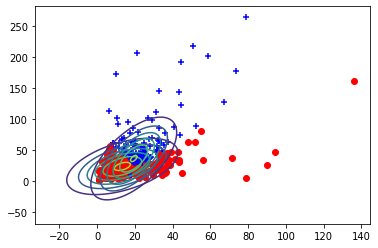

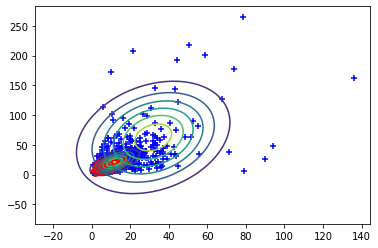

In [12]:
data = dataset[['so2', 'no2']]
data = data[:500]
data = np.array(data)

# Initialize GMM algorithm
n_components = 2
gmm_model = GMM(n_components)

# Fit GMM to the data
gmm_model.fit(data)

# Cluster data
labelled = gmm_model.cluster(data)

# Plot clustered data with the location of Gaussian mixtures
plt.figure()

# Plot contours of Gaussian mixtures
for mean, cov in zip(gmm_model.means, gmm_model.covariances):
    # Create grid
    mean_x = mean[0]
    std_x = np.sqrt(cov[0][0])
    mean_y = mean[1]
    std_y = np.sqrt(cov[1][1])
    x = np.linspace(mean_x - 3*std_x, mean_x + 3*std_x, 100)
    y = np.linspace(mean_y - 3*std_y, mean_y + 3*std_y, 100)
    X, Y = np.meshgrid(x, y)

    # Tabulate pdf values
    Z = np.empty(X.shape, np.float)

    for i in np.arange(X.shape[0]):
        for j in np.arange(X.shape[1]):
            v = np.array([X[i][j], Y[i][j]])
            Z[i][j] = gmm_model.multivariate_normal_pdf(v, mean, cov)

    # Plot contours
    print('its contour')
    plt.contour(X, Y, Z)

# Plot features assigned to each Gaussian mixture
markers = ['o', '+']
colors = ['r', 'b']
print('final plot')
print(data.shape)
print(labelled)
for d, l  in zip(data, labelled):
    plt.scatter(d[0], d[1], color=colors[l], marker=markers[l])
plt.savefig('scatter_plot.pdf')

features before shuffled:  (500, 2)
features_shuffled:  (500, 2)

features_split :  250
features split [ 0 ] shape :  (250, 2)
features split [ 1 ] shape :  (250, 2)
mean shape:  (2, 2)
cov   features split [ 0 ] shape :  (250, 2)
cov   features split [ 1 ] shape :  (250, 2)
cov shape:  (2, 2, 2)
its contour
its contour
intial plot
mixing_probs shape:  (2,)
features shape:  (2,)
its contour
its contour
final plot
(500, 2)
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1
 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0
 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0
 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 

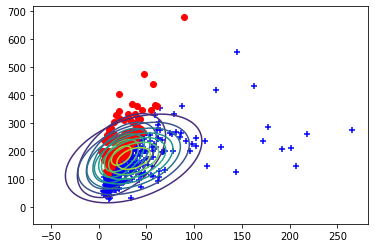

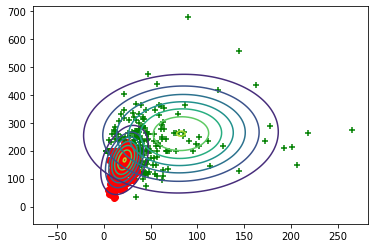

In [13]:
data = dataset[['no2', 'spm']]
data = data[:500]
data = np.array(data)


# Initialize GMM algorithm
n_components = 2
gmm_model = GMM(n_components)

# Fit GMM to the data
gmm_model.fit(data)

# Cluster data
labelled = gmm_model.cluster(data)

# Plot clustered data with the location of Gaussian mixtures
plt.figure()

# Plot contours of Gaussian mixtures
for mean, cov in zip(gmm_model.means, gmm_model.covariances):
    # Create grid
    mean_x = mean[0]
    std_x = np.sqrt(cov[0][0])
    mean_y = mean[1]
    std_y = np.sqrt(cov[1][1])
    x = np.linspace(mean_x - 3*std_x, mean_x + 3*std_x, 100)
    y = np.linspace(mean_y - 3*std_y, mean_y + 3*std_y, 100)
    X, Y = np.meshgrid(x, y)

    # Tabulate pdf values
    Z = np.empty(X.shape, np.float)

    for i in np.arange(X.shape[0]):
        for j in np.arange(X.shape[1]):
            v = np.array([X[i][j], Y[i][j]])
            Z[i][j] = gmm_model.multivariate_normal_pdf(v, mean, cov)

    # Plot contours
    print('its contour')
    plt.contour(X, Y, Z)

# Plot features assigned to each Gaussian mixture
markers = ['o', '+']
colors = ['r', 'g']
print('final plot')
print(data.shape)
print(labelled)
for d, l  in zip(data, labelled):
    plt.scatter(d[0], d[1], color=colors[l], marker=markers[l])
plt.savefig('scatter_plot.pdf')

features before shuffled:  (500, 2)
features_shuffled:  (500, 2)

features_split :  250
features split [ 0 ] shape :  (250, 2)
features split [ 1 ] shape :  (250, 2)
mean shape:  (2, 2)
cov   features split [ 0 ] shape :  (250, 2)
cov   features split [ 1 ] shape :  (250, 2)
cov shape:  (2, 2, 2)
its contour
its contour
intial plot
mixing_probs shape:  (2,)
features shape:  (2,)
its contour
its contour
final plot
(500, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0
 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1
 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1
 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 

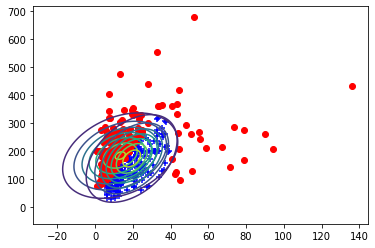

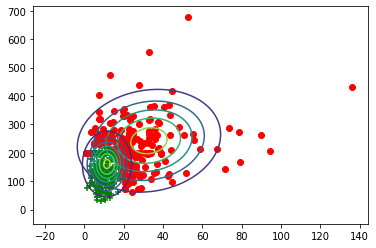

In [14]:
data = dataset[['so2', 'spm']]
data = data[:500]
data = np.array(data)


# Initialize GMM algorithm
n_components = 2
gmm_model = GMM(n_components)

# Fit GMM to the data
gmm_model.fit(data)

# Cluster data
labelled = gmm_model.cluster(data)

# Plot clustered data with the location of Gaussian mixtures
plt.figure()

# Plot contours of Gaussian mixtures
for mean, cov in zip(gmm_model.means, gmm_model.covariances):
    # Create grid
    mean_x = mean[0]
    std_x = np.sqrt(cov[0][0])
    mean_y = mean[1]
    std_y = np.sqrt(cov[1][1])
    x = np.linspace(mean_x - 3*std_x, mean_x + 3*std_x, 100)
    y = np.linspace(mean_y - 3*std_y, mean_y + 3*std_y, 100)
    X, Y = np.meshgrid(x, y)

    # Tabulate pdf values
    Z = np.empty(X.shape, np.float)

    for i in np.arange(X.shape[0]):
        for j in np.arange(X.shape[1]):
            v = np.array([X[i][j], Y[i][j]])
            Z[i][j] = gmm_model.multivariate_normal_pdf(v, mean, cov)

    # Plot contours
    print('its contour')
    plt.contour(X, Y, Z)

# Plot features assigned to each Gaussian mixture
markers = ['o', '+']
colors = ['r', 'g']
print('final plot')
print(data.shape)
print(labelled)
for d, l  in zip(data, labelled):
    plt.scatter(d[0], d[1], color=colors[l], marker=markers[l])
plt.savefig('scatter_plot.pdf')